In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [3]:
def read_csv(file):
    df = pd.read_csv(file, parse_dates=True, index_col=0)
    return df

In [4]:
def print_confusion_matrix(tn, fp, fn, tp):
    print("    ","True", "False")
    print("True ", " ", tp, "  ", fp)
    print("False", " ",fn,"  ", tn)
    print("_______________________________________")
    print("---------------------------------------")

In [5]:
def format(val, pos):
    if val == 0:
        return "BULL"
    if val == 1:
        return "BEAR"
    else:
        return ""

In [6]:
def plot(real, imputed):
    fig, ax = plt.subplots(figsize=(20,4))
    ax.xaxis.set_major_locator(plt.MaxNLocator(50))
    ax.plot(real.index, real, '-', label="Real Data", color='blue')
    ax.plot(real.index, imputed, '-', label="Imputed Data", color='red')
    ax.legend(['Real Data', 'Predicted Data'])
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format))
    ax.set_ylim(-0.1, 1.1)
    fig.autofmt_xdate()
    plt.show()

## XGBoost for Moving Average imputed dataset


In [7]:
best_params = {
    'colsample_bytree': 0.3, 
    'gamma': 0, 
    'learning_rate': 0.1,
    'max_delta_step': 3, 
    'max_depth': 1, 
    'min_child_weight': 5, 
    'n_estimators': 400, 
    'reg_alpha': 0.1, 
    'scale_pos_weight': 100, 
    'subsample': 0.5}


_______________________________________
______________Training_________________
F1 score 0.9802371541501977
     True False
True    372    15
False   0    395
_______________________________________
---------------------------------------
_______________Testing_________________
F1 score nan
     True False
True    0    0
False   65    207
_______________________________________
---------------------------------------
---------------------------------------


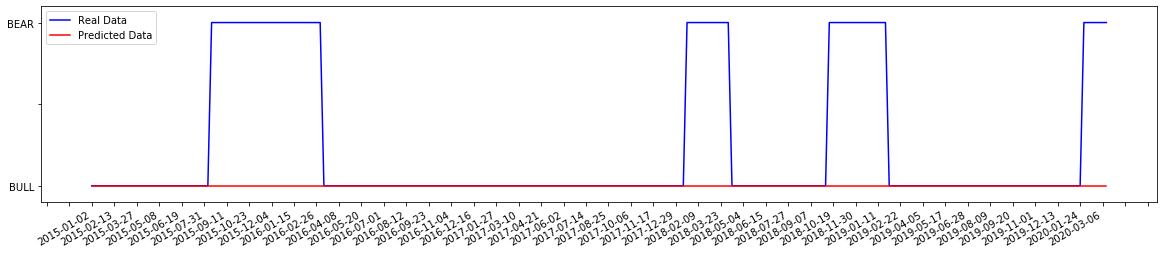

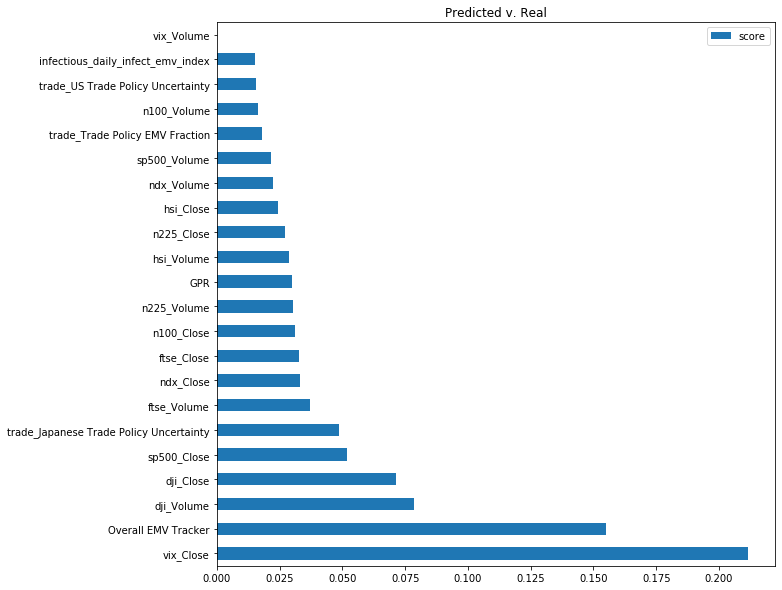

In [10]:
X_train = read_csv('output/\MovingAverageWeeklyImputed_training.csv')
X_test = read_csv('output/\MovingAverageWeeklyImputed_test.csv')
X_test = X_test.loc['2015-01-02':'2020-03-13']
y = pd.read_csv('input/\sp500_target_regimes.csv', parse_dates=True)
y.index = y['date'].values
y = y[['regime']]
y = y['regime']=='BEAR'
y = pd.DataFrame (y, columns = ['regime'])

y_train = y.loc['2000-01-01':'2015-01-01']
y_test = y.loc['2015-01-02':]

xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                                  eval_metric = 'auc',
                                  learning_rate=best_params['learning_rate'], 
                                  n_estimators=best_params['n_estimators'], 
                                  min_child_weight=best_params['min_child_weight'], 
                                  gamma=best_params['gamma'],
                                  max_delta_step=best_params['max_delta_step'],
                                  max_depth=best_params['max_depth'],
                                  subsample=best_params['subsample'],
                                  scale_pos_weight=best_params['scale_pos_weight'],
                                  colsample_bytree=best_params['colsample_bytree'],
                                  reg_alpha=best_params['reg_alpha']
                              )

model = xgb_model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print("_______________________________________")
print("______________Training_________________")
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = 2*precision*recall/(precision+recall)  
print("F1 score", f_score)
print_confusion_matrix(tn, fp, fn, tp)
print("_______________Testing_________________")
y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = 2*precision*recall/(precision+recall)
print("F1 score", f_score)
print_confusion_matrix(tn, fp, fn, tp)
print("---------------------------------------")

#plot bear bull imputed and real
plot(y_test, y_pred)
# feature importance
data = pd.DataFrame(data=xgb_model.feature_importances_, index=X_train.columns, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh', title="Predicted v. Real", figsize=(10,10))
